In [17]:
from numcosmo_py import Ncm, Nc, GObject

import numpy as np
import math
import sys
from astropy.io import fits
from astropy.table import Table

%matplotlib inline
import matplotlib.pyplot as plt

import pygtc
import pandas as pd

from getdist import plots
from getdist.mcsamples import  MCSamples
import getdist
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

from IPython.display import display, Math

from richness_mass_calib import create_richness_mass_calib

#Settings
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

GetDist Version: 1.4.5, Matplotlib version: 3.7.2


In [2]:
# Data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"
)
dt_halos = Table(DC2_halos_m200c[1].data)

rmdata = create_richness_mass_calib(dt_halos)

ascaso = Nc.ClusterMassAscaso()
lnrich_ext = Nc.ClusterMassLnrichExt()

ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.688627943224023)
ascaso.param_set_by_name("mup2", 1.23735536845047)
ascaso.param_set_by_name("sigmap0", 0.227197277810533)
ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
ascaso.param_set_by_name("sigmap2", -0.125446104089159)


lnrich_ext = Nc.ClusterMassLnrichExt()
lnrich_ext.param_set_by_name("mu", 4.60456407051582)
lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

lnrich_ext.param_set_by_name("cut", 1e15)
lnrich_ext.param_set_by_name("cutM1", 0)
lnrich_ext.param_set_by_name("cutZ1", 0)

# lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
# lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
# lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)
 

dset = Ncm.Dataset.new()
dset.append_data(rmdata)
lh = Ncm.Likelihood.new(dset)

mset = Ncm.MSet()
mset.set(ascaso)

#mset.param_set (7000, 6, 100)
mset.param_set_all_ftype(Ncm.ParamType.FREE)
mset.param_set_ftype(7000, 6, Ncm.ParamType.FIXED)
mset.prepare_fparam_map()

fit = Ncm.Fit.new( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL)

fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:08.4931320
#  iteration            [000159]
#  function evaluations [000161]
#  gradient evaluations [000000]
#  degrees of freedom   [454469]
#  m2lnL     =     124009.843405234 (     124009.84 )
#  Fit parameters:
#     4.45396746379709     0.688633920612188    1.23737027983131     0.227177969614783   -0.0514063872135474  -0.125445467426676   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 0.0012095116690034    
#  - relative improvement: 9.75335202427621e-09  
#  - m2lnL_0  :            124009.844614745      
#  - m2lnL_1  :           

In [3]:
fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  4.45396746379709    [FREE]
#   -    mup1[01]:  0.688633920612188   [FREE]
#   -    mup2[02]:  1.23737027983131    [FREE]
#   - sigmap0[03]:  0.227177969614783   [FREE]
#   - sigmap1[04]: -0.0514063872135474  [FREE]
#   - sigmap2[05]: -0.125445467426676   [FREE]
#   -     cut[06]:  6                   [FIXED]


In [4]:
nwalkers = 300

Ncm.func_eval_set_max_threads(1)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(1)
esmcmc.set_data_file("ResultsESMCMC/Ascaso_mcmc1.fits")

esmcmc.start_run()
esmcmc.run(1000)  
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()


# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      1
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0300.
#   Number of threads: 0001.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  4.45413402239804    [FREE]
#   -    mup1[01]: 

In [5]:
esmcmc.mean_covar()
fit.log_covar()

#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                   -------------------------------------------------------------------------------------------
#    mup0[07000:00] =  4.454       +/-  0.004997    |  1           |  0.6137      |  0.0198      | -0.1241      | -0.07104     | -0.02604     |
#    mup1[07000:01] =  0.6886      +/-  0.001182    |  0.6137      |  1           |  0.1874      | -0.1657      | -0.1484      | -0.09088     |
#    mup2[07000:02] =  1.237       +/-  0.002134    |  0.0198      |  0.1874      |  1           | -0.0843      | -0.06011     |  0.1025      |
# sigmap0[07000:03] =  0.2272      +/-  0.00179     | -0.1241      | -0.1657      | -0.0843      |  1           |  0.731       | -0.08621     |
# sigmap1[07000:04] = -0.0514      +/-  0.0006955   | -0.07104     | -0.1484      | -0.06011     |  0.731       |  1           |  0.1599      |
# sigmap2[070

In [6]:
fit.log_info()


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  4.45398282789854    [FREE]
#   -    mup1[01]:  0.688637351620562   [FREE]
#   -    mup2[02]:  1.2373084134625     [FREE]
#   - sigmap0[03]:  0.22722924658147    [FREE]
#   - sigmap1[04]: -0.0513981421903718  [FREE]
#   - sigmap2[05]: -0.125489818291725   [FREE]
#   -     cut[06]:  6                   [FIXED]


In [35]:
data_fit_full = pd.DataFrame(fits.open("ResultsESMCMC/Ascaso_mcmc1.fits")[1].data).iloc[:, 1:6].T
data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '1',
    '2',
    '3',
    '4',
    '5',
]
labels=["\mu_{0}", "\mu_{1}", "\mu_{2}", "\sigma_{0}", "\sigma_{1}", "\sigma_{2}"]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples1 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples1.removeBurn(0.3)

Removed no burn in


300000

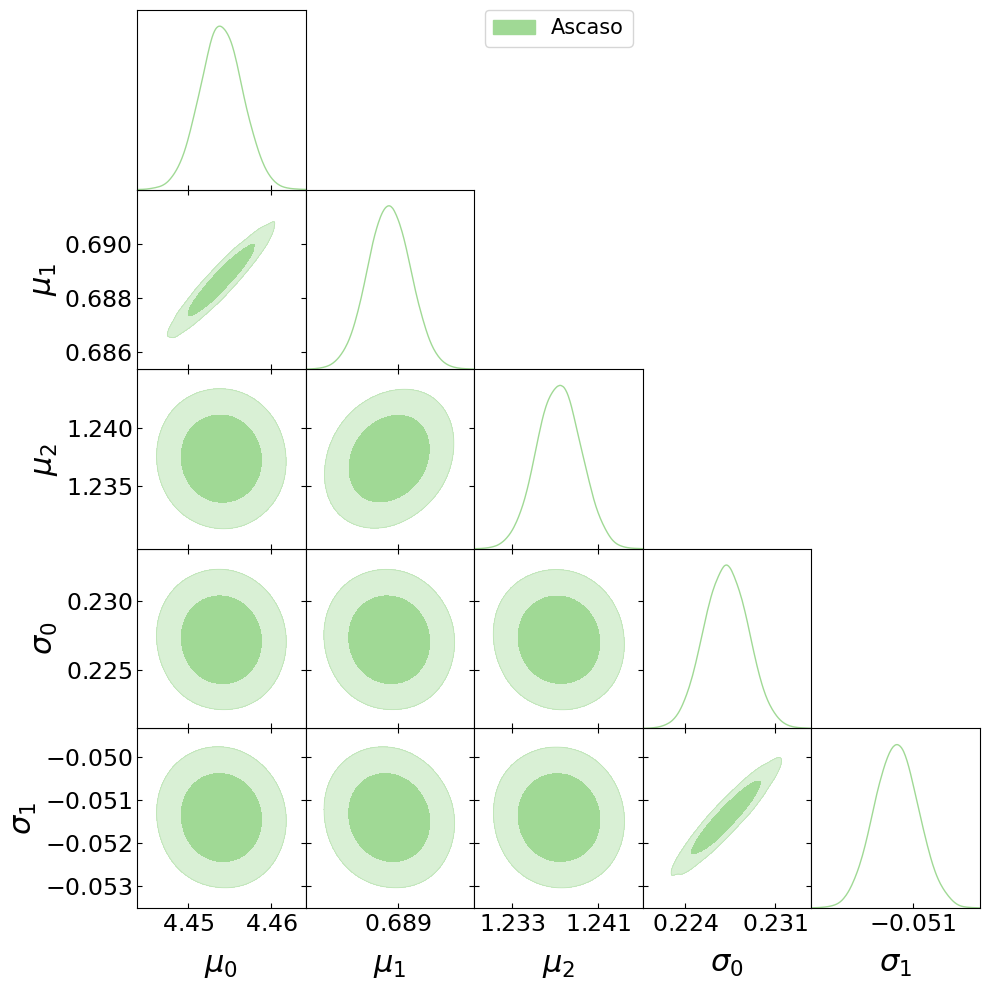

<IPython.core.display.Math object>

In [60]:
# Triangle plot
g1 = plots.get_subplot_plotter()

g1.settings.legend_fontsize = 18
g1.settings.lab_fontsize = 25
g1.settings.axes_fontsize = 20


g1.triangle_plot(
    [samples1],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fontsize=14,
    fine_bins=1,
    colors=['#a0d995'],
    line_args=[{'lw':1.2,'ls':'-', 'color':'#a0d995'}],
    legend_labels=["Ascaso"],
)



plt.show()
display(Math(samples.getInlineLatex('1',limit=1)))



In [9]:
mset = Ncm.MSet()
mset.set(lnrich_ext)

mset.param_set_all_ftype(Ncm.ParamType.FREE)
mset.param_set_ftype(7000, 12, Ncm.ParamType.FIXED)
mset.param_set_ftype(7000, 13, Ncm.ParamType.FIXED)
mset.param_set_ftype(7000, 14, Ncm.ParamType.FIXED)

mset.prepare_fparam_map()

fit = Ncm.Fit.new( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL)

fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.....................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:16.9729420
#  iteration            [000287]
#  function evaluations [000289]
#  gradient evaluations [000000]
#  degrees of freedom   [454463]
#  m2lnL     =     120211.143686005 (     120211.14 )
#  Fit parameters:
#     4.60456256760908     0.872081906375356    1.77443452023304     0.0417736875884975  -0.140733846234012    0.142283846359744    0.288102726731959    0.0166507570672618  -0.0169865949595185   0.015169207827622    0.00838940717097166  0.0375302267013702  
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0.000125412

In [10]:
fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.60456256760908    [FREE]
#   -    muM1[01]:  0.872081906375356   [FREE]
#   -    muZ1[02]:  1.77443452023304    [FREE]
#   -    muM2[03]:  0.0417736875884975  [FREE]
#   -    muZ2[04]: -0.140733846234012   [FREE]
#   -    muMZ[05]:  0.142283846359744   [FREE]
#   -  sigma0[06]:  0.288102726731959   [FREE]
#   - sigmaM1[07]:  0.0166507570672618  [FREE]
#   - sigmaZ1[08]: -0.0169865949595185  [FREE]
#   - sigmaM2[09]:  0.015169207827622   [FREE]
#   - sigmaZ2[10]:  0.00838940717097166 [FREE]
#   - sigmaMZ[11]:  0.0375302267013702  [FREE]
#   -     cut[12]:  1e+15               [FIX

In [11]:
nwalkers = 2200

Ncm.func_eval_set_max_threads(4)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(4)
esmcmc.set_data_file("ResultsESMCMC/Ext_mcmc1.fits")

esmcmc.start_run()
esmcmc.run(1040)  
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()


# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      4
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 2200.
#   Number of threads: 0004.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.60129767511253    [FREE]
#   -    muM1[01

In [12]:
esmcmc.mean_covar()
fit.log_covar()

#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                   -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#      mu[07000:00] =  4.606       +/-  0.014       |  1           |  0.8881      |  0.02637     |  0.7621      | -0.04674     |  0.0135      |  0.2556      |  0.3063      |  0.2494      |  0.3036      | -0.0258      |  0.2447      |
#    muM1[07000:01] =  0.8728      +/-  0.009988    |  0.8881      |  1           |  0.1887      |  0.944       | -0.02141     |  0.1717      |  0.3011      |  0.3473      |  0.2274      |  0.3426      |  0.01355     |  0.2383      |
#    muZ1[07000:02] =  1.773       +/-  0.01527     |  0.02637     |  0.1887      |  1           |  0.2703      | -0.1128      |  0.838       |  0.02362     |  0.009366    | -

In [37]:
data_fit_full = pd.DataFrame(fits.open("ResultsESMCMC/Ext_mcmc1.fits")[1].data).iloc[:, 1:13].T
data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr= np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    '10',
    '11',
    '12',
]
labels=["\mu_0", "\mu_{M1}", "\mu_{M2}", "\mu_{Z1}"," \mu_{Z2}", "\mu_{MZ}", "\sigma_0", "\sigma_{M1}", "\sigma_{M2}", "\sigma_{Z1}", "\sigma_{Z2}", "\sigma_{MZ}" ]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples2 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples2.removeBurn(0.3)


Removed no burn in


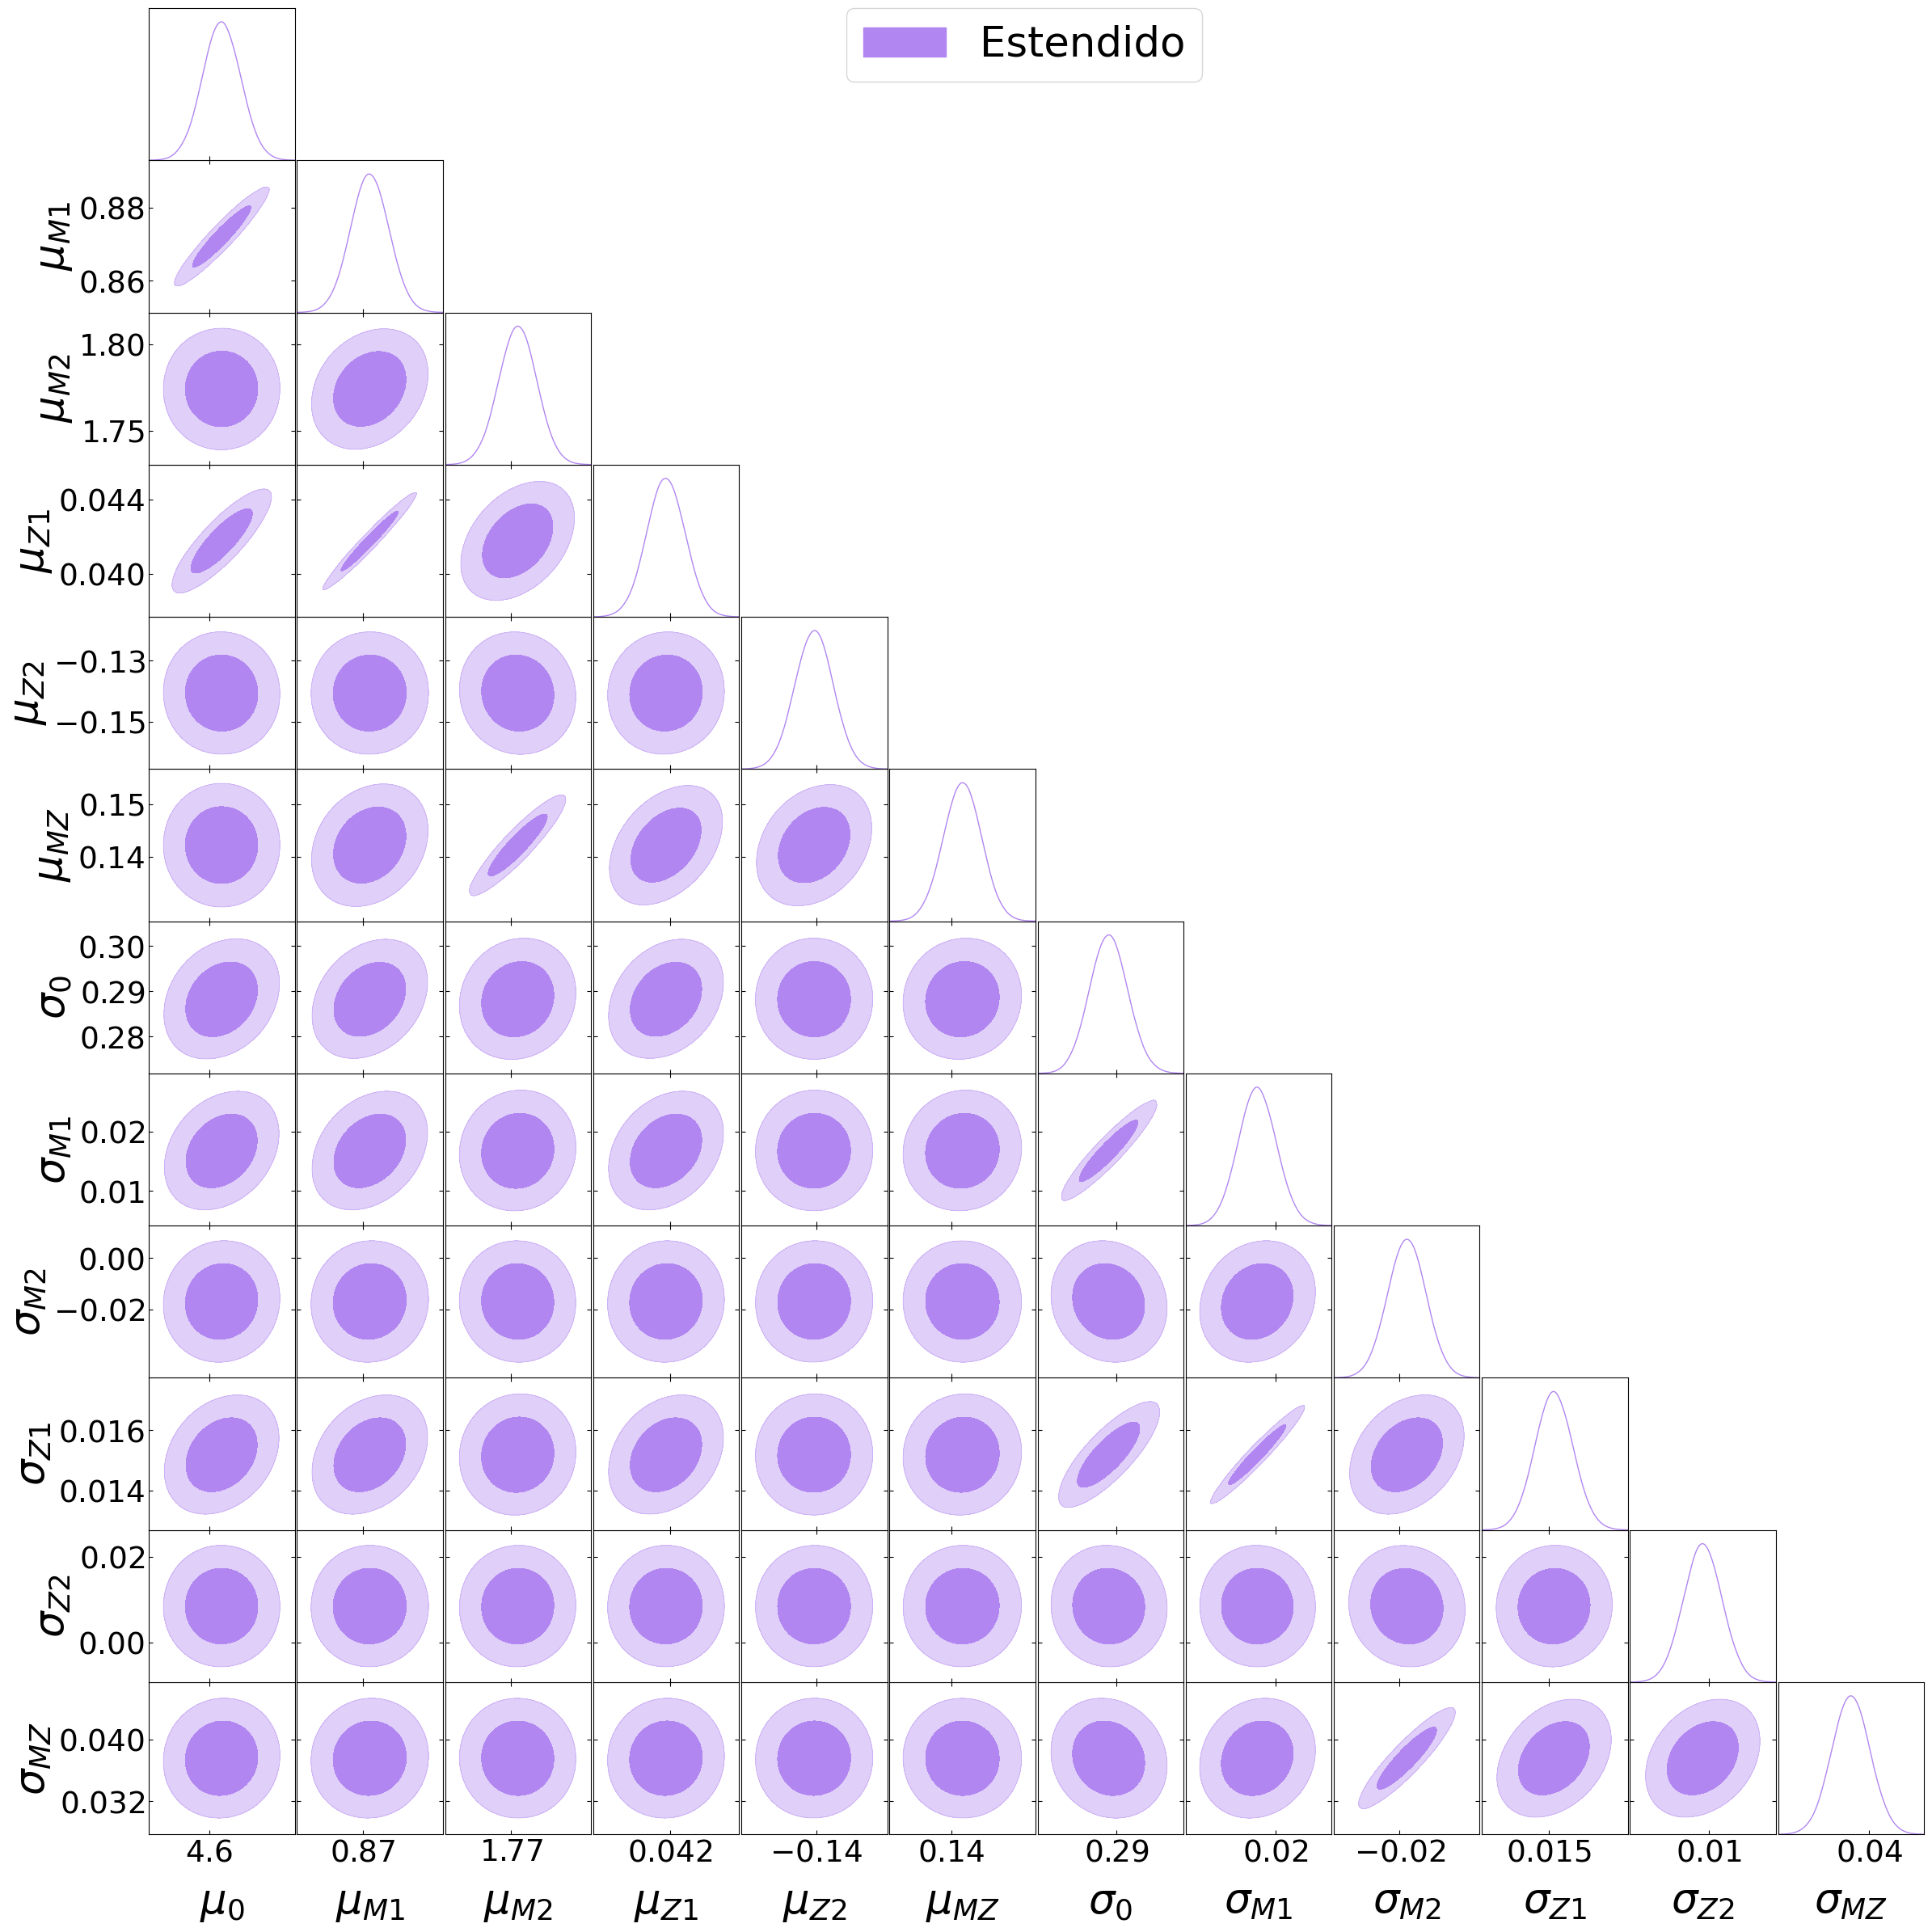

<IPython.core.display.Math object>

In [65]:
# Triangle plot
g2 = plots.get_subplot_plotter()

g2.settings.lab_fontsize = 40
g2.settings.legend_fontsize = 40
g2.settings.axes_fontsize = 30

g2.triangle_plot(
    [samples2],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=['#b186f1'],
    fontsize=70,
    line_args=[{'lw':1.2,'ls':'-', 'color':'#b186f1'}],
    legend_labels=["Estendido", ],
)



plt.show()
display(Math(samples.getInlineLatex('1',limit=1)))



In [68]:
data_fit_full = pd.DataFrame(fits.open("ResultsESMCMC/Ext_mcmc1.fits")[1].data).iloc[:, 1:13]

len(data_fit_full)

2288000